# Examining the Unemployment Rate

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px

import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

In [3]:
unemployment = pd.read_csv("data/unemployment.csv")
unemployment.head()

,Series ID,Year,Period,Label,Value
0,LNU04000000,1948,M01,1948 January,4.0
1,LNU04000000,1948,M02,1948 February,4.7
2,LNU04000000,1948,M03,1948 March,4.5
3,LNU04000000,1948,M04,1948 April,4.0
4,LNU04000000,1948,M05,1948 May,3.4


In [13]:
df = unemployment.set_index(pd.to_datetime(unemployment['Label'], format='mixed')).drop(['Series ID', 'Year', 'Period', 'Label'],axis=1)
df.head()

,Value
Label,
1948-01-01,4.0
1948-02-01,4.7
1948-03-01,4.5
1948-04-01,4.0
1948-05-01,3.4


Text(0, 0.5, '% Unemployment')

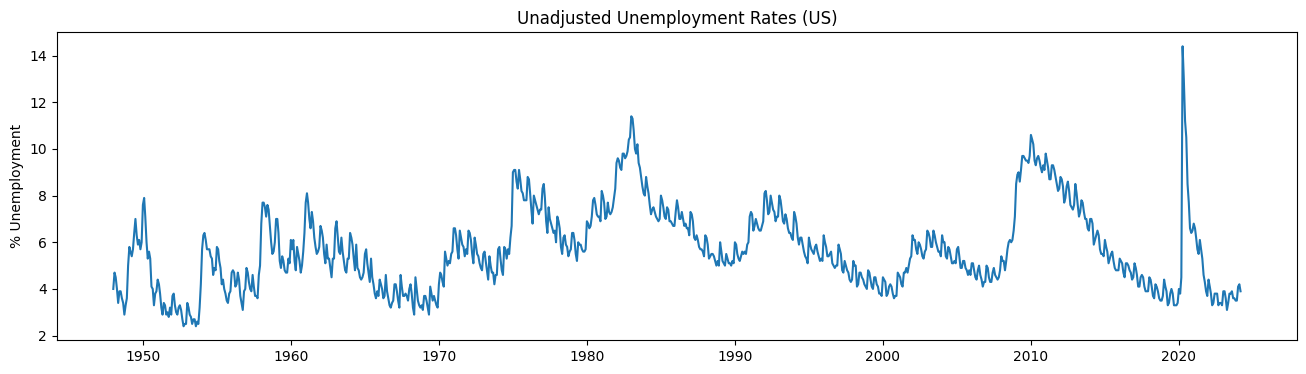

In [136]:
plt.figure(figsize=(16,4))
plt.plot(df)
plt.title('Unadjusted Unemployment Rates (US)')
plt.ylabel('% Unemployment')

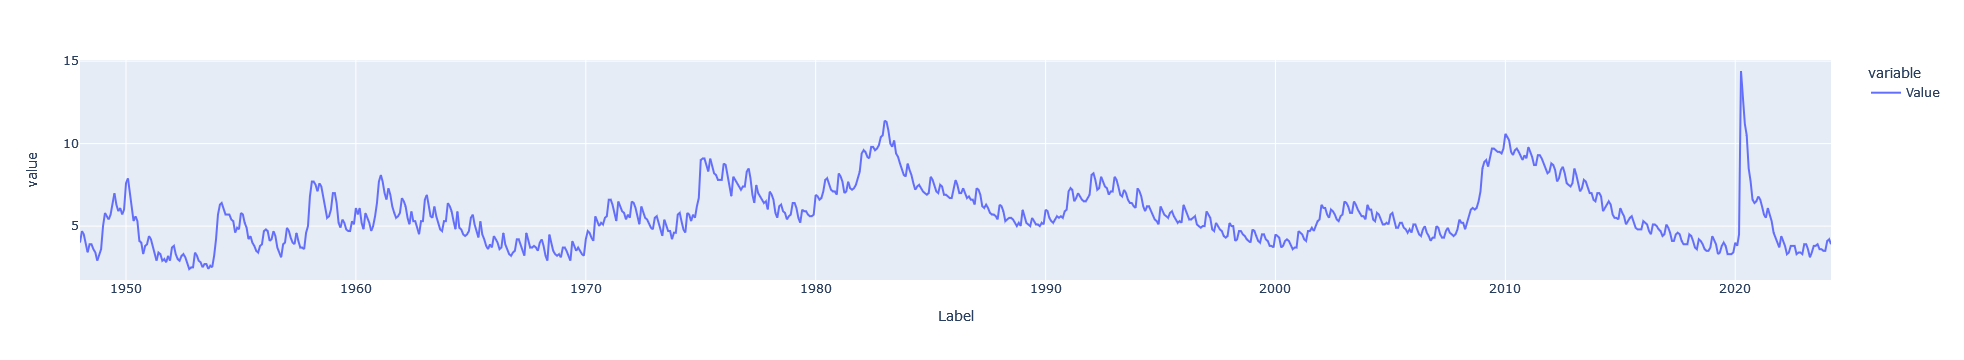

In [22]:
px.line(df)

In [24]:
adfuller(df)

(-3.0397191832782724,
 0.03134795959087748,
 21,
 893,
 {'1%': -3.437694005510983,
  '5%': -2.8647819837978683,
  '10%': -2.5684962548451375},
 1286.9649428075008)

The *p*-value of the Dickey-Fuller statistic is < .05, but not < .01. We could reject the null hypothesis that the data is not stationary, but there are some clear patterns in the data in the latter half. Try running the test for only after 1980, but leave out the COVID spike.

In [31]:
adfuller(df['01-01-1980':'01-01-2020'])

(-2.3872752906440473,
 0.1453601192374525,
 16,
 464,
 {'1%': -3.4445220811896657,
  '5%': -2.8677891615873192,
  '10%': -2.5700985643950656},
 -129.54515881582597)

The *p*-value is > .05. I believe it is justifiable to truncate the data to this range; policy shifts over time, along with advanced economic forecasting, has led to a fundamental shift in the policies related to unemployment (and therefore a difference in the stochastic processes that drive unemployment numbers). COVID is a historic anomaly, and should probably be left out of the modeling data.

Split dataset into time period between high in early 80's and 2010, and see how well it predicts 2010 - 2020.

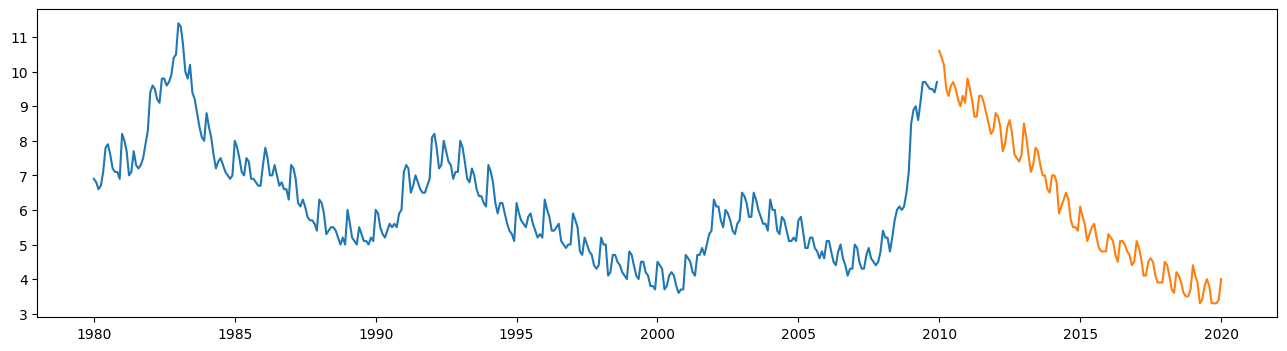

In [56]:
y_hist = df['01-01-1980':'12-12-2009']
y_future = df['01-01-2010':'01-01-2020']

plt.figure(figsize=(16,4))
plt.plot(y_hist)
plt.plot(y_future)

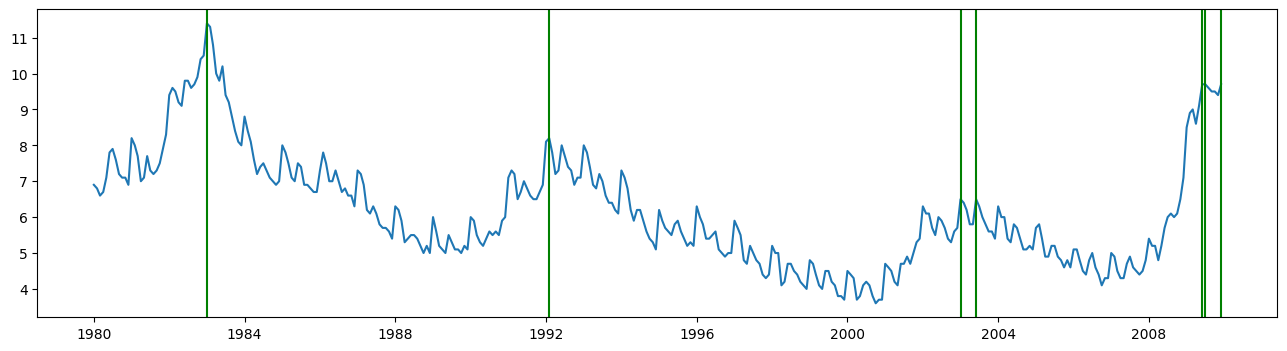

In [75]:
# Find local maxima (period: 5 years, or 60 months)
k = 60
local_maxima_values = []
local_maxima_index = []
local_maxima_location = []
for i in range(0, len(y_hist)):
    index_low = max(i-k, 0)
    index_high = min(i+k, len(y_hist))
    temp_check = y_hist.iloc[index_low:index_high,0]
    temp_val = y_hist.iloc[i,0]
    if max(temp_check) == temp_val:
        local_maxima_index.append(y_hist.index[i])
        local_maxima_values.append(y_hist.iloc[i,0])
        local_maxima_location.append(i)

plt.figure(figsize=(16,4))
plt.plot(y_hist)
for maxima in local_maxima_index:
    plt.axvline(x=maxima, color='green')

In [76]:
pd.DataFrame({'time': local_maxima_index, 'value': local_maxima_values})

,time,value
0,1983-01-01,11.4
1,1992-02-01,8.2
2,2003-01-01,6.5
3,2003-06-01,6.5
4,2009-06-01,9.7
5,2009-07-01,9.7
6,2009-12-01,9.7


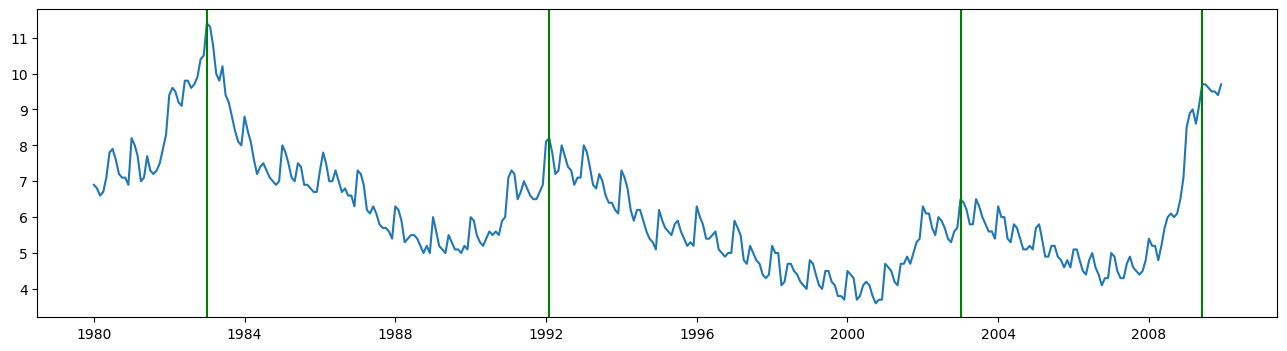

In [77]:
# remove a few values from local_maxima_index and local_maxima_values
del_index = [6,5,3]
for ind_to_del in del_index:
    del local_maxima_index[ind_to_del]
    del local_maxima_values[ind_to_del]
    del local_maxima_location[ind_to_del]

plt.figure(figsize=(16,4))
plt.plot(y_hist)
for maxima in local_maxima_index:
    plt.axvline(x=maxima, color='green')

In [82]:
np.diff(local_maxima_location).mean().astype(int)

105

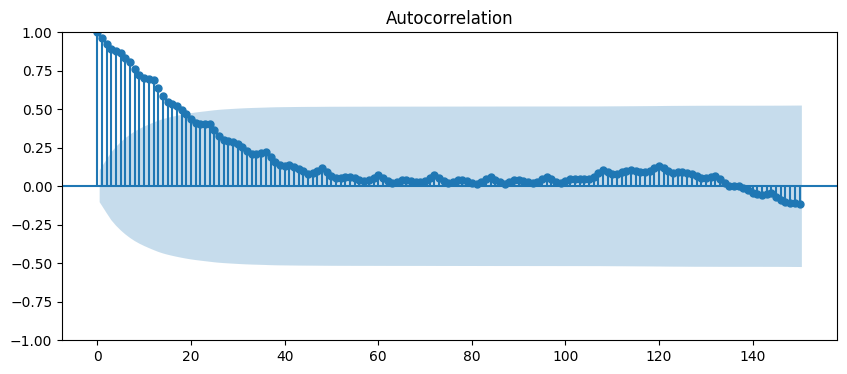

In [100]:
# View any autocorrelation; set lag high enough to see periods of 105 months
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(y_hist, lags = 150, ax=ax)
plt.show()

In [166]:
# Consistent peaks within the ACF function, which correspond to notable trends in the data.
# We'll go with a period of 105 months, or ~8.75 years
y_hist = df['01-01-1980':'12-12-2009']

#stl = STL(y_hist, period = 105)
#stl = STL(df[:'12-12-2009'], period = 105)
#results = stl.fit()

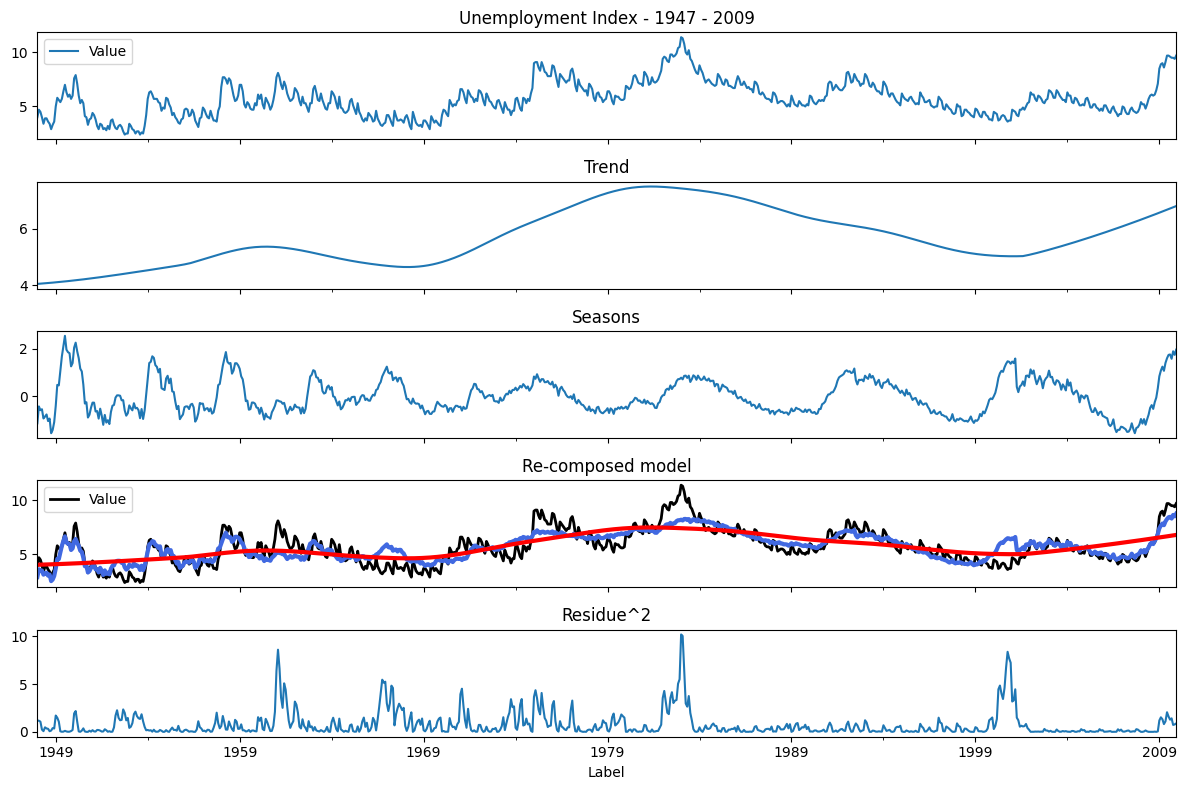

In [168]:
stl = STL(df[:'12-12-2009'], period = 105)
results = stl.fit()

fig, axs = plt.subplots(ncols = 1, nrows = 5, sharex = True, figsize = (12,8))
results.observed.plot(ax = axs[0], title ='Unemployment Index - 1947 - 2009')
results.trend.plot(ax = axs[1], title ='Trend')
results.seasonal.plot(ax = axs[2], title ='Seasons')
# recomposition
season_and_trend = results.trend + results.seasonal
results.observed.plot(ax = axs[3], title = 'Re-composed model', color='black', linewidth=2)
season_and_trend.plot(ax=axs[3], label='trend & seasonal', color='royalblue', linewidth=3)
results.trend.plot(ax=axs[3], label='trend', color='red',linewidth=3)
# residue
(results.resid**2).plot(ax = axs[4], title ='Residue^2')

plt.tight_layout()
#plt.ylabel('% unemployment')
plt.show()

In [166]:
# Consistent peaks within the ACF function, which correspond to notable trends in the data.
# We'll go with a period of 105 months, or ~8.75 years

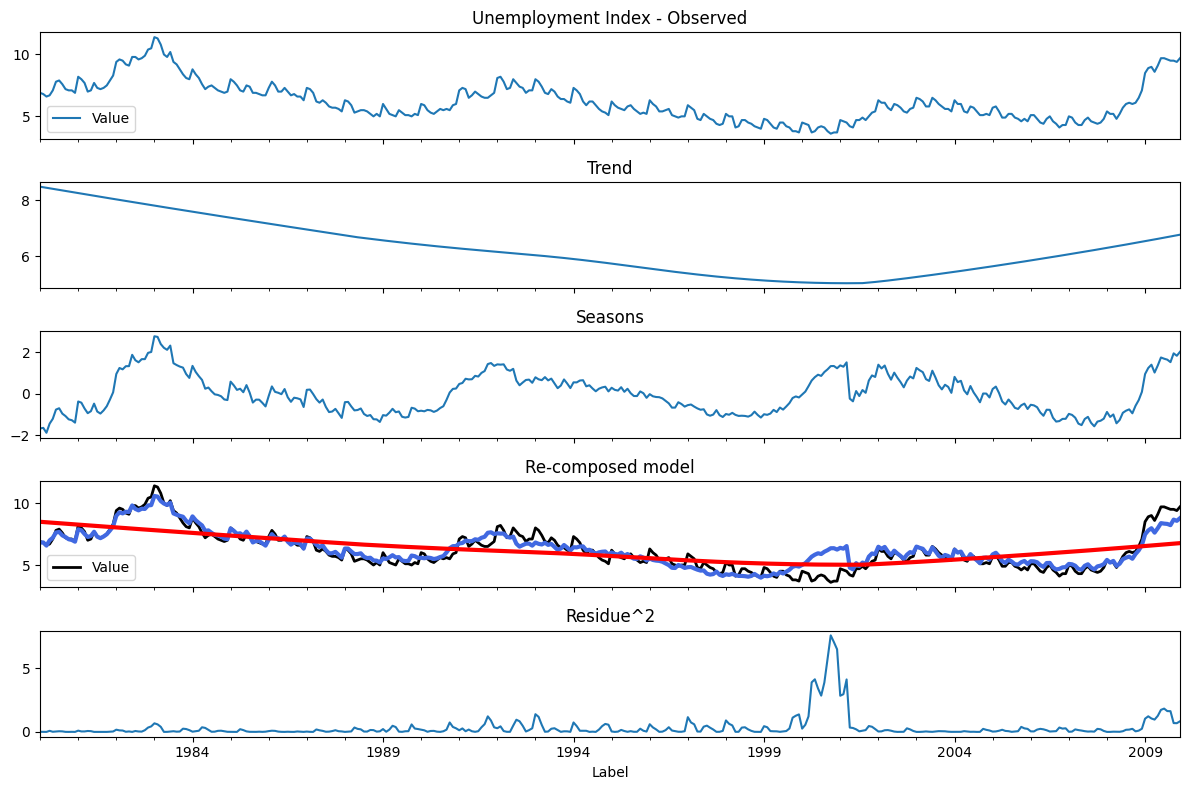

In [169]:
stl = STL(df['01-01-1980':'12-12-2009'], period = 105)
results = stl.fit()

fig, axs = plt.subplots(ncols = 1, nrows = 5, sharex = True, figsize = (12,8))
results.observed.plot(ax = axs[0], title ='Unemployment Index - 1980 - 2009')
results.trend.plot(ax = axs[1], title ='Trend')
results.seasonal.plot(ax = axs[2], title ='Seasons')
# recomposition
season_and_trend = results.trend + results.seasonal
results.observed.plot(ax = axs[3], title = 'Re-composed model', color='black', linewidth=2)
season_and_trend.plot(ax=axs[3], label='trend & seasonal', color='royalblue', linewidth=3)
results.trend.plot(ax=axs[3], label='trend', color='red',linewidth=3)
# residue
(results.resid**2).plot(ax = axs[4], title ='Residue^2')

plt.tight_layout()
#plt.ylabel('% unemployment')
plt.show()

In [130]:
MSE = (results.resid**2).mean()
RMSE = np.sqrt(MSE)
RMSE

0.8825442651876434

# Forecast

Now, try to predict based on the fit model

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



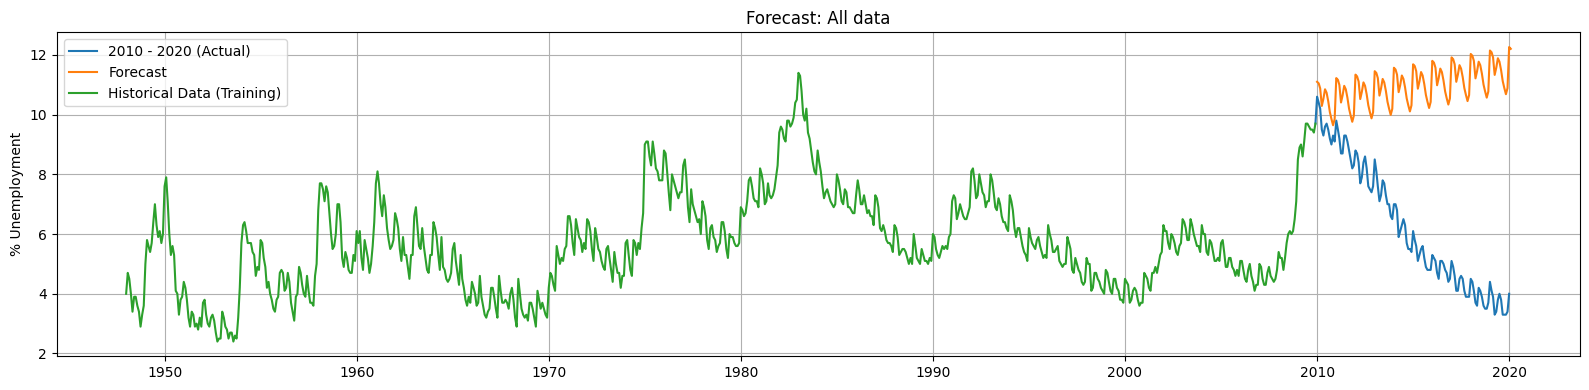

In [171]:
y_hist = df[:'12-12-2009']
#y_hist = df['01-01-1980':'12-12-2009']
#y_hist = y_hist[local_maxima_index[0]:]
y_future = df[y_hist.index[-1]:'01-01-2020']

stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"})
stlf_results = stlf.fit()
forecast = stlf_results.forecast(len(y_future))

plt.figure(figsize=(16,4))
plt.plot(y_future, label = '2010 - 2020 (Actual)')
plt.plot(forecast, label = 'Forecast')
plt.plot(y_hist, label = 'Historical Data (Training)')
plt.legend()
plt.title('Forecast: All data')
plt.ylabel("% Unemployment")
plt.grid()
plt.tight_layout() ; plt.show()

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



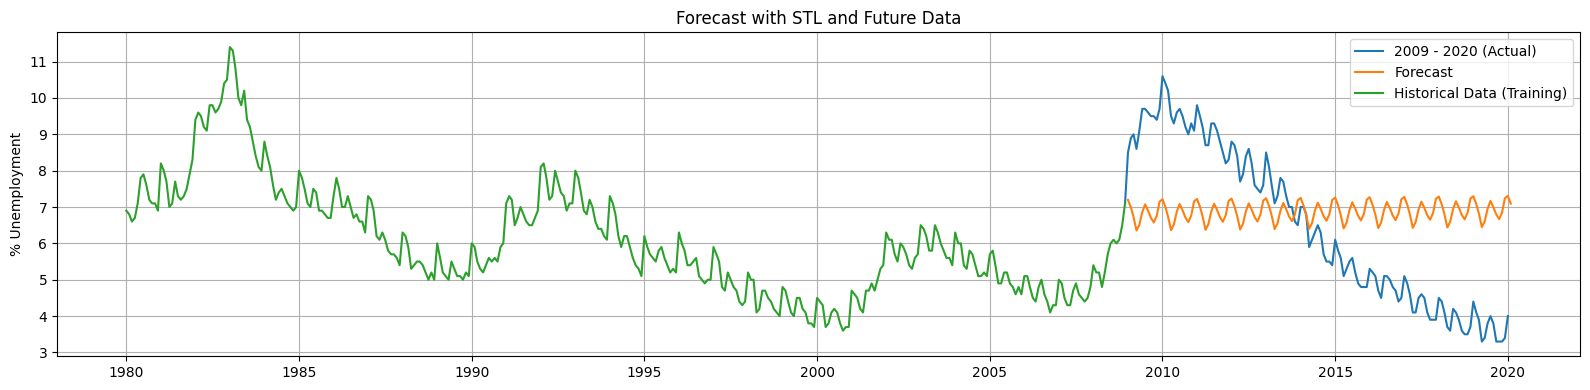

In [160]:
#y_hist = df[:'12-12-2009']
#y_hist = df['01-01-1980':'12-12-2009']
#y_hist = y_hist[local_maxima_index[0]:]
y_hist = df['01-01-1980':'12-12-2008']
y_future = df[y_hist.index[-1]:'01-01-2020']

stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"})
stlf_results = stlf.fit()
forecast = stlf_results.forecast(len(y_future))

plt.figure(figsize=(16,4))
plt.plot(y_future, label = '2009 - 2020 (Actual)')
plt.plot(forecast, label = 'Forecast')
plt.plot(y_hist, label = 'Historical Data (Training)')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid()
plt.ylabel("% Unemployment")
plt.tight_layout() ; plt.show()

Timestamp('1983-01-01 00:00:00')

In [138]:
y_future.tail()

,Value
Label,
2019-09-01,3.3
2019-10-01,3.3
2019-11-01,3.3
2019-12-01,3.4
2020-01-01,4.0
